## **Introduction to Image Processing**

## Interpolation and Blending

 Importing necessary libraries/modules and functions

In [5]:
% matplotlib inline
% pprint off


# Import the library as show images, plot, etc.
import matplotlib.pyplot as plt
# Import functionality for the color map
import matplotlib.cm as cm

# Import system specific parameters and function
import sys 

## Other plotting libraries
# import seaborn as sns

# Import the library to mange the matrix and array 
import numpy as np

# Importing image processing toolbox 
## Module to read, write,... 
from skimage import io
## Module to convert the image on 8 bits
from skimage import img_as_ubyte
## Module to convert the image to float
from skimage import img_as_float
## Module for color conversion 
from skimage import color
## Module image transform from skimage for resize 
from skimage import transform
## Module misc from scipy for resize 
from scipy import misc
## Module util from skimage 
from PIL import Image

Pretty printing has been turned OFF


### ** Resizing an image size using different interpolation functions**

**1. ** Resize the lena or vibot image using nearest, bilinear and bicubic function.

You can define your function which accept the model and resize size from the user or just run a script.

In [6]:


def resize(img, factor):
    #if factor is int a precentage scalling, 
    #if it's float fraction scalling, 
    #and tuple the size of the output image
    fig = plt.figure()

    #nearest neighbour 
    img_nearest = misc.imresize(img, factor, 'nearest')
    im1 = fig.add_subplot(1,3,1)
    im1.imshow(img_nearest)
    im1.set_title('Nearest')

    #bilinear
    img_bilinear = misc.imresize(img, factor, 'bilinear')
    im2 = fig.add_subplot(1,3,2)
    im2.imshow(img_bilinear)
    im2.set_title('Bilinear')

    #bicubic
    img_bicubic = misc.imresize(img, factor, 'bicubic')
    im3 = fig.add_subplot(1,3,3)
    im3.imshow(img_bicubic)
    im3.set_title('Bicubic')

    return img_nearest, img_bilinear, img_bicubic



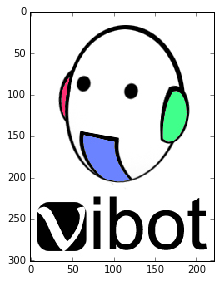

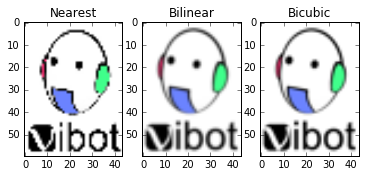

In [7]:
img_vibot = io.imread('./images/vibot-color.jpg')
io.imshow(img_vibot)
 
img_vibot_resize = resize(img_vibot, 20)

**2. ** Similar to the function of `my_blending.m` that you saw before define your function of blending.

Blend the lena image and vibot image using simple, alpha and pyramid method.   

Pyramid blending method: 
1. Create a mask the same size as your input images 
2. Create Laplacian pyramid of the input images 
    2.1. Create Gaussian pyramids of the input images
    2.2. Create Laplacian pyramids using the Gaussian pyramids
3. Create Gaussian pyramid for the region mask
4. Blend the two laplacian pyramids using the pyramid of the mask as weigh 
    $$ BL = L_1 * (GM) + L_2 *(1 - GM)$$
5. Colapse the pyramid to get the final image 
    $$rescale(rescale(rescale(BL_3)+BL_2)+BL_1)+BL_0$$

Note : For pyramid blending approach, you can use:
    * transform.rescale for upscaling your images
    * transform.pyramid_gaussian for building your pyramids
    * The output of transform.pyramid_gaussian is a type generator and you need to convert it to a list :
    
        b = [a for a in Gaussian_pyramid]


In [8]:
from skimage.transform import rescale


def blending(img1, img2, method, alpha=0.5):
    #img1 = color.rgb2gray(img1)
    #img2 = color.rgb2gray(img2)
    img3 = np.zeros(img1.shape)
    
    mid_point = round(img1.shape[1]/2)
    
    if img1.shape != img2.shape:
        img2 = transform.resize(img2, img1.shape)
    
    #simple blending
    if method == 'simple':
        img3[:,:mid_point] = img1[:,:mid_point]
        img3[:,mid_point:] = img2[:,mid_point:]
    
    #alpha blending
    if method == 'alpha':
        img3[:,:mid_point-alpha] = img1[:,:mid_point-alpha]
        img3[:,mid_point+alpha:] = img2[:,mid_point+alpha:]
        #in the middle
        mid1 = mid_point-alpha
        mid2 = mid_point+alpha
        mid = np.zeros(mid1,mid2)
        
        img3[:,mid] = alpha*img1[:, mid] + (1-alpha)*img2[:,mid]
        
    #pyramid blending   
    if method == 'pyramid':
        Gaussian_pyramid1 = transform.pyramid_gaussian(img1, max_layer=3)
        Gaussian_pyramid2 = transform.pyramid_gaussian(img2, max_layer=3)
        #mask
        mask = np.zeros(img1.shape)
        for i in range(mid_point):
            mask[:,i] = 1
        
        Gaussian_pyramid3 = transform.pyramid_gaussian(mask, max_layer=3)
        #lists
        b1 = [a for a in Gaussian_pyramid1]
        b2 = [a for a in Gaussian_pyramid2]
        b3 = [a for a in Gaussian_pyramid3]
        
        #Laplacian
        l1 = list(b1)
        l2 = list(b2)
        for i in range(len(b1)-1):
            if i == len(b1)-1:
                l1[i]=b1[i]
                l2[i]=b2[i]
            else:
                l1[i] = b1[i] - rescale(b1[i+1], 2)
                l2[i] = b2[i] - rescale(b2[i+1], 2)
        
        bl = list(l1)
        for i in range(len(l1)-1):
            bl[i] = b3[i]*l1[i] + (1 - b3[i])*l2[i]
        
        
        img3 = rescale(rescale(rescale(bl[3], 2) + bl[2], 2) + bl[1], 2) + bl[0]
        
    return img3

Use the `orange.jpeg` and `apple.jpeg` imgages and blend them using simple, alpha and pyramid approach.

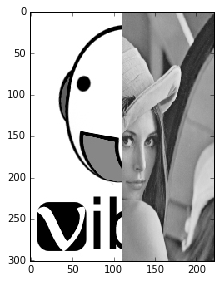

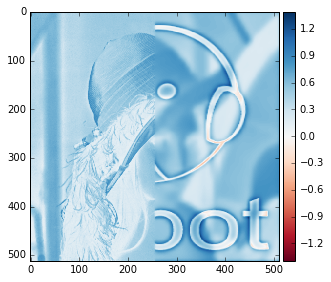

In [9]:
img_vibot = io.imread('./images/vibot-color.jpg', as_grey=True)
img_lena = io.imread('./images/lena-grey.bmp')

#simple
lena_vibot1 = blending(img_vibot, img_lena, 'simple')
io.imshow(lena_vibot1)
plt.show()

#alpha
#lena_vibot2 = blending(img_lena, img_vibot, 'alpha')
#io.imshow(lena_vibot2)
plt.show()

#pyramid
lena_vibot3 = blending(img_lena, img_vibot, 'pyramid')
io.imshow(lena_vibot3)
plt.show()

In [12]:
apple_im = io.imread('./images/apple.jpeg')
orange_im = io.imread('./images/orange.jpeg')

/home/cloudera/anaconda3/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


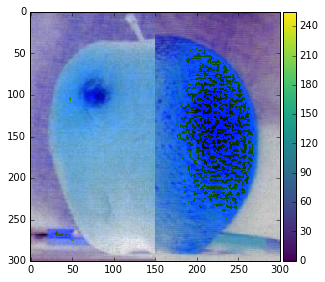

ValueError: operands could not be broadcast together with shapes (75,75,3) (76,76,3) 

In [13]:
#simple
apple_orange1 = blending(apple_im, orange_im, 'simple')
io.imshow(apple_orange1)
plt.show()

#alpha
#apple_orange2 = blending(apple_im, orange_im, 'alpha')
#io.imshow(apple_orange2)
plt.show()

#pyramid
apple_orange3 = blending(apple_im, orange_im, 'pyramid')
io.imshow(apple_orange3)
plt.show()


Show the your answers.